In [296]:
import numpy as np
np.random.seed(1)

import skimage
from skimage.util import view_as_windows
from skimage import io, color, filters
from scipy.ndimage import gaussian_filter, maximum_filter

from scipy.signal import convolve2d
from scipy.ndimage import maximum_filter # different than max pooling
import os

import matplotlib.pyplot as plt

In [297]:
class SingleImages():
    def __init__(self,generate_crops = False):
        path = "single_wide_images"
        self.single_images = list()
        self.crops = list()
        
        for file in os.listdir(path):
            img = skimage.io.imread(path + "/" + file)
            self.single_images.append(img)
       
        if generate_crops: 
            for img in self.single_images:
                cropped = self.crop_image_with_overlap(img)
                cropped = [skimage.transform.rotate(c, np.random.randint(-5,5)) for c in cropped]
                self.crops.append(cropped)
            
    
    @staticmethod
    def plot_image(img, figsize = (15,8)):
        plt.figure(figsize=figsize)
        plt.imshow(img,cmap="Blues")
        plt.axis("off")
    
    @staticmethod
    def crop_image_with_overlap(image, num_horizontal_splits=2, num_vertical_splits=2, overlap_fraction=0.45):
        height, width = image.shape[:2]
        crop_height = height // num_vertical_splits
        crop_width = width // num_horizontal_splits
        overlap_h = int(crop_height * overlap_fraction)
        overlap_w = int(crop_width * overlap_fraction)

        crops = []

        for i in range(num_vertical_splits):
            for j in range(num_horizontal_splits):
                start_row = max(0, i * crop_height - overlap_h * i)
                start_col = max(0, j * crop_width - overlap_w * j)
                end_row = min(height, start_row + crop_height + overlap_h)
                end_col = min(width, start_col + crop_width + overlap_w)
                crop = image[start_row:end_row, start_col:end_col]
                crops.append(crop)

        return crops

    def plot_crops(self, img, num_horizontal_splits=2, num_vertical_splits=2):
        plt.figure(figsize=(15, 8))
        for i, crop in enumerate(img):
            plt.subplot(num_vertical_splits, num_horizontal_splits, i + 1)
            plt.imshow(crop)
            plt.axis('off')
        plt.show()



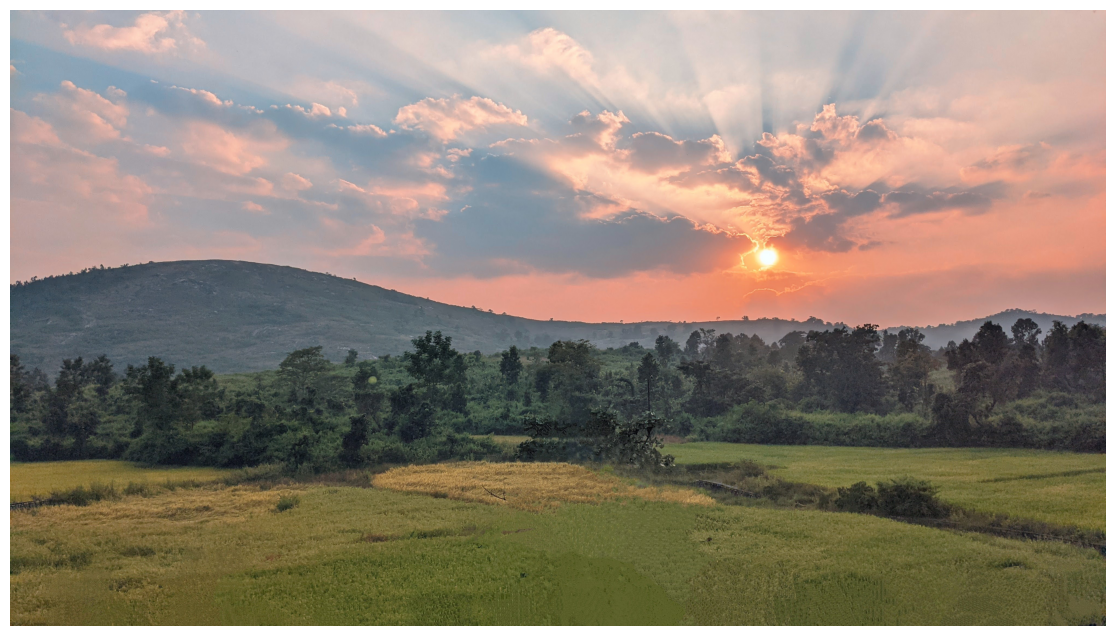

In [298]:
si = SingleImages(generate_crops=True)
si.plot_image(si.single_images[0])


Augmenting the images to see robustness to small jitter with rotation (Note we dont consider rescaling..)

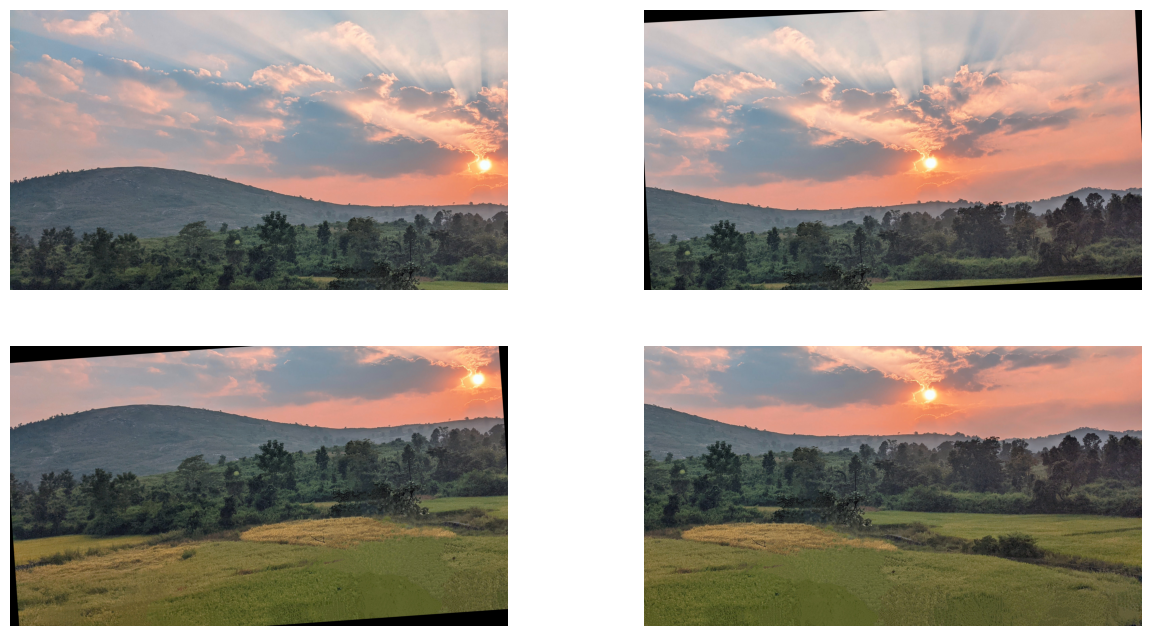

In [299]:
si.plot_crops(si.crops[0])

More Realistic Examples

In [300]:
class PairWise:
    def __init__(self):
        path = "difficult_examples"
        self.pair_images_names = " # 0 pond L, 1 Himalyan L , Mountain 2 , Himalayan R 3 , Mountain R , pond 5"
        self.pair_images = list()
        for file in os.listdir(path):
            img = skimage.io.imread(path + "/" + file)
            self.pair_images.append(img)

        self.pond = [self.pair_images[0], self.pair_images[5] ]
        self.mountain = [self.pair_images[2], self.pair_images[4] ]
        self.himalyan = [self.pair_images[1], self.pair_images[3] ]
        self.pair_images = [self.pond , self.himalyan , self.mountain]
            
    def plot_pair(self,ix):
        plt.figure(figsize=(15,8))
        plt.subplot(1,2,1)
        plt.imshow(self.pair_images[ix][0])
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(self.pair_images[ix][1])
        plt.axis("off")

        

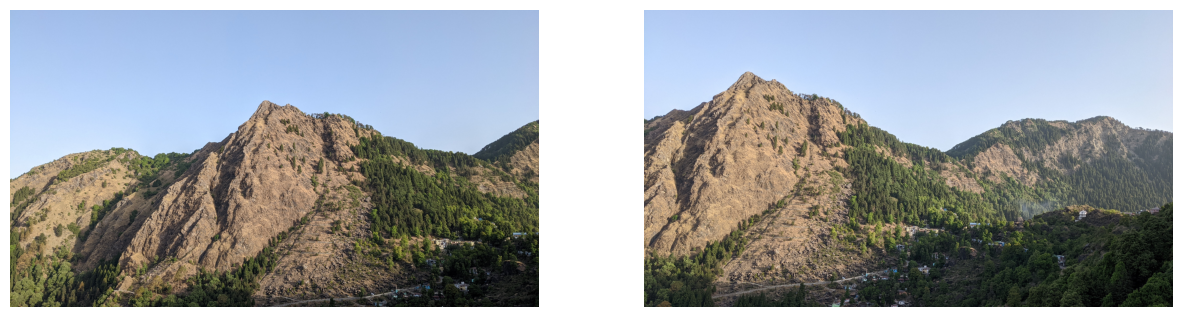

In [301]:
pi = PairWise() # 0 pond L, 1 Himalyan L , Mountain 2 , Himalayan R 3 , Mountain R , pond 5
pi.plot_pair(2)

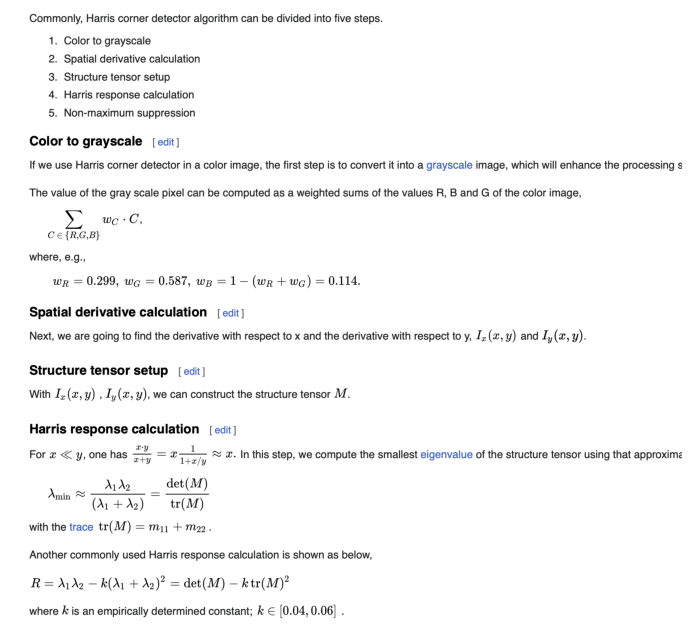

In [302]:
# steps from wikiepedia : https://en.wikipedia.org/wiki/Harris_corner_detector
si.plot_image(skimage.io.imread("Harris_Wikipedia.png"))

In [374]:
class Transformations:
    @staticmethod
    def grey_scale(I):
        return 0.299 * I[:,:,0] + 0.587 * I[:,:,1] + 0.114 * I[:,:,2]

    @staticmethod
    def convolve(I, k):
        return convolve2d(I, k, mode='same', boundary='fill', fillvalue=0)

    @staticmethod
    def first_order_grad(I):
        return skimage.filters.sobel_h(I), skimage.filters.sobel_v(I)

    @staticmethod
    def normalize(arr,scale=254):
        return ((arr - arr.min())/ (arr.max() - arr.min()) * scale)

    @staticmethod
    def calculate_M(Ix, Iy, sigma=1.5):
        Ixx = gaussian_filter(Ix**2, sigma)
        Iyy = gaussian_filter(Iy**2, sigma)
        Ixy = gaussian_filter(Ix*Iy, sigma)
        # does not exactly return block Matrix of M but all its entries
        return Ixx, Iyy, Ixy

    @staticmethod
    def harris_response(Ixx, Iyy, Ixy, k=0.04):
        detM = Ixx * Iyy - Ixy**2
        traceM = Ixx + Iyy
        return detM - k * traceM**2

    @staticmethod # from wikipedia
    def non_maximum_suppression(response, size=3):
        data_max = maximum_filter(response, size=size)
        mask = (response == data_max)
        return response * mask

    @staticmethod
    def harris_corner_detector(img, sigma=1.5, k=0.04, threshold=0.01, plot_overlay = True):
        image = img
        if image.ndim == 3:
            image = Transformations.grey_scale(image)

        Ix, Iy = Transformations.first_order_grad(image)
        Ixx, Iyy, Ixy = Transformations.calculate_M(Ix, Iy, sigma)
        HR = Transformations.harris_response(Ixx, Iyy, Ixy, k)
        response = Transformations.non_maximum_suppression(HR)

        # Thresholding
        corners = np.zeros_like(response)
        corners[response > threshold * response.max()] = 1
        
        if plot_overlay:
            plt.figure(figsize=(15,8))
            plt.imshow(img)
            plt.scatter(np.where(corners)[1], np.where(corners)[0], color='r', s=1)
            plt.title('Hand Calculated Harris Corners')
            plt.axis("off")
            plt.show()
        return response , corners




In [419]:
import cv2 # only to validate our results
class HarrisDetector(Transformations):
    @staticmethod
    def hand_harris_corner_detector(img, sigma=1.5, k=0.04, threshold=0.01, plot_overlay = True):
        image = img
        if image.ndim == 3:
            image = HarrisDetector.grey_scale(image)

        Ix, Iy = HarrisDetector.first_order_grad(image)
        Ixx, Iyy, Ixy = HarrisDetector.calculate_M(Ix, Iy, sigma)
        HR = HarrisDetector.harris_response(Ixx, Iyy, Ixy, k)
        response = HarrisDetector.non_maximum_suppression(HR)

        # Thresholding
        corners = np.zeros_like(response)
        corners[response > threshold * response.max()] = 1
        
        if plot_overlay:
            HarrisDetector.plot_overlay(corners,"Hand Calculated Harris Corner Detector")
        
        return response, corners
    
    
    @staticmethod
    def opencv_implementation(img,blockSize = 2 , ksize=3,k=0.04 , plot_overlay = True):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        dst = cv2.dilate(dst, None)
        corners = dst > 0.01 * dst.max()
        
        if plot_overlay:
            HarrisDetector.plot_overlay(corners,"OpenCV Implementattion")
        return corners
    
    def compare_opencv(self,img):
        _,hand_corners = self.harris_corner_detector(img,plot_overlay=False)
        open_cv_corners = self.opencv_implementation(img,plot_overlay=False)
        fig, ax = plt.subplot_mosaic("AB",figsize=(15,8))
        ax["A"].imshow(img)
        ax["A"].scatter(np.where(hand_corners)[1], np.where(hand_corners)[0], color="r", s=1)
        ax["A"].set_title("Hand Calculated Harris Corners")
        ax["B"].imshow(img)
        ax["B"].scatter(np.where(open_cv_corners)[1], np.where(open_cv_corners)[0], color="b", s=1)
        ax["B"].set_title("Open CV2 Calculated Harris Corners")
        ax["A"].axis("off")
        ax["B"].axis("off")
        plt.show()
       
        
        
    @staticmethod
    def plot_overlay(corners,title):
        plt.figure(figsize=(15,8))
        plt.imshow(img)
        plt.scatter(np.where(corners)[1], np.where(corners)[0], color='r', s=1)
        plt.title(title)
        plt.axis("off")
        plt.show()



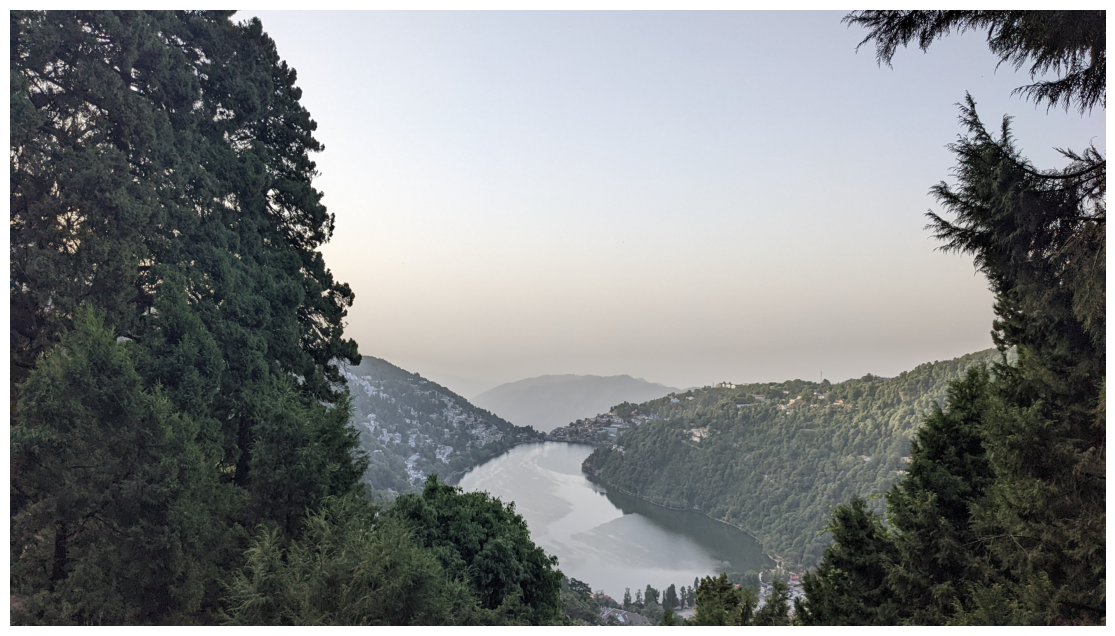

In [436]:
# lets work with this image for HR response detection
img = pi.pond[0]
si.plot_image(img)
hd = HarrisDetector()

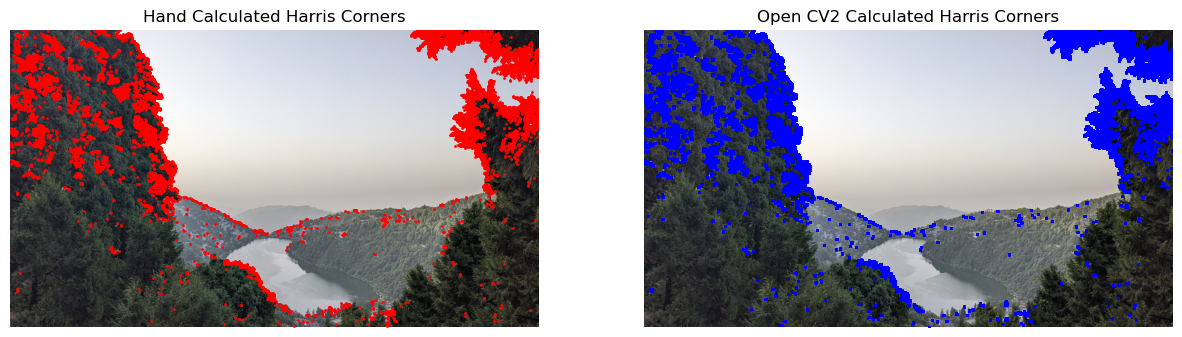

In [437]:
hd.compare_opencv(img)

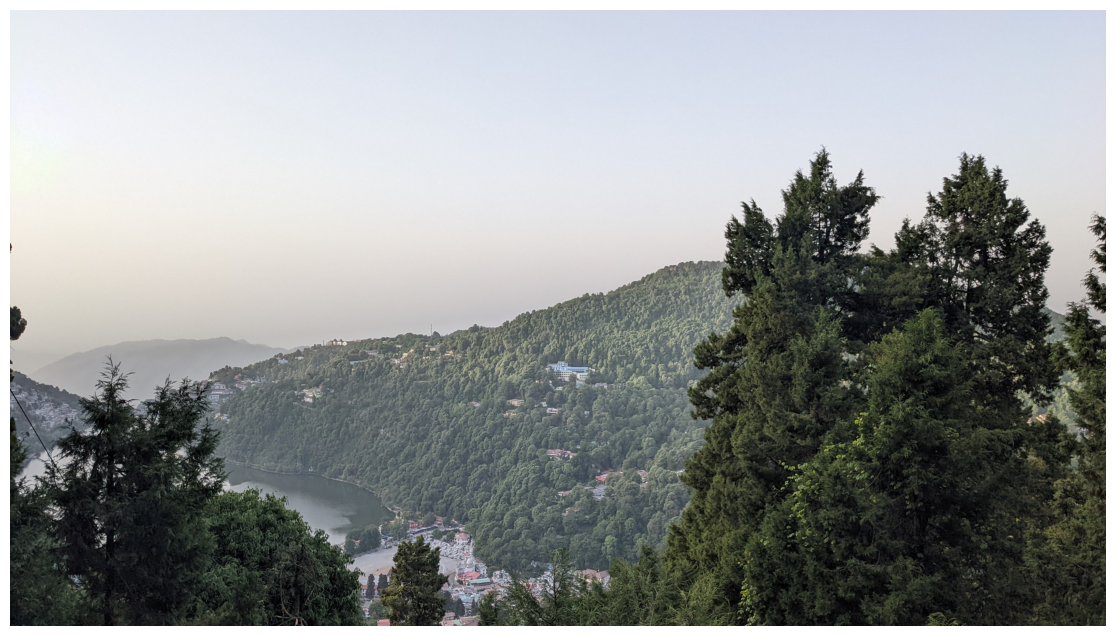

In [438]:
# lets work with this image for HR response detection
img = pi.pond[1]
si.plot_image(img)
hd = HarrisDetector()

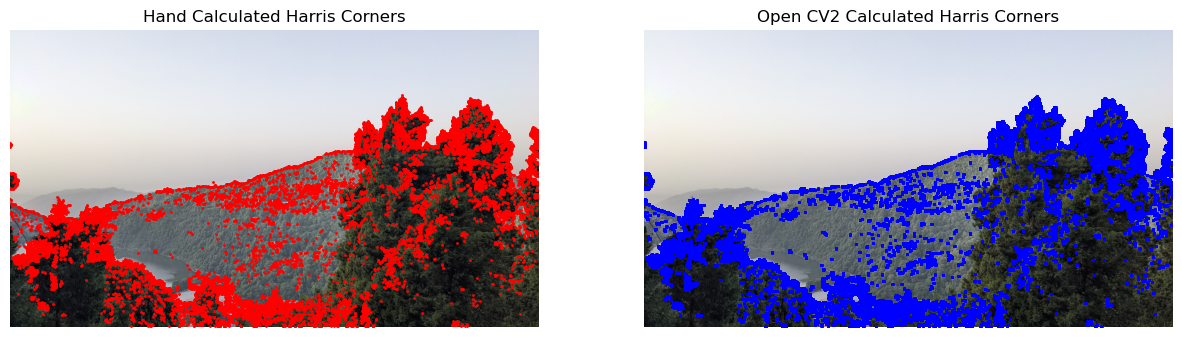

In [440]:
hd.compare_opencv(img)